In [7]:
import pandas as pd
import numpy as np
import time
from preprocessing import *
from HDEM import *

set_seed(47)

In [8]:
df = pd.read_csv(r'output_csv\HCMUT-SuperNodeXP-2017-1.0.swf.csv')
# df = df.head(100)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15886 entries, 0 to 15885
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   job_id                    15886 non-null  float64
 1   submit_time               15886 non-null  float64
 2   wait_time                 15886 non-null  float64
 3   run_time                  15886 non-null  float64
 4   num_allocated_processors  15886 non-null  float64
 5   avg_cpu_time_used         15886 non-null  float64
 6   used_memory               15886 non-null  float64
 7   requested_processors      15886 non-null  float64
 8   requested_time            15886 non-null  float64
 9   requested_memory          15886 non-null  float64
 10  status                    15886 non-null  float64
 11  user_id                   15886 non-null  float64
 12  group_id                  15886 non-null  float64
 13  executable_id             15886 non-null  float64
 14  queue_

In [9]:
df.head()

,job_id,submit_time,wait_time,run_time,num_allocated_processors,avg_cpu_time_used,used_memory,requested_processors,requested_time,requested_memory,status,user_id,group_id,executable_id,queue_id,partition_id,preceding_job_id,think_time
0,4.0,0.0,0.0,13.0,24.0,7.0,14761.0,24.0,21600.0,218453.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0
1,8.0,40819.0,0.0,61.0,24.0,45.0,14761.0,24.0,21600.0,218453.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0
2,10.0,45255.0,0.0,60.0,24.0,45.0,14760.0,24.0,21600.0,218453.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0
3,11.0,45782.0,0.0,1.0,24.0,0.0,0.0,24.0,21600.0,218453.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0
4,12.0,56510.0,0.0,1.0,24.0,0.0,0.0,24.0,21600.0,218453.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0


In [10]:
feature_columns = ['requested_processors', 'requested_time', 'avg_cpu_time_used', 'used_memory', 'submit_time', 'wait_time', 'user_id', 'group_id', 'executable_id', 'queue_id']
target_column = 'run_time'

X_train, X_val, X_test, Y_train, Y_val, Y_test, scaler = prepare_data_DL(df, feature_columns, target_column)

Key on Test Set


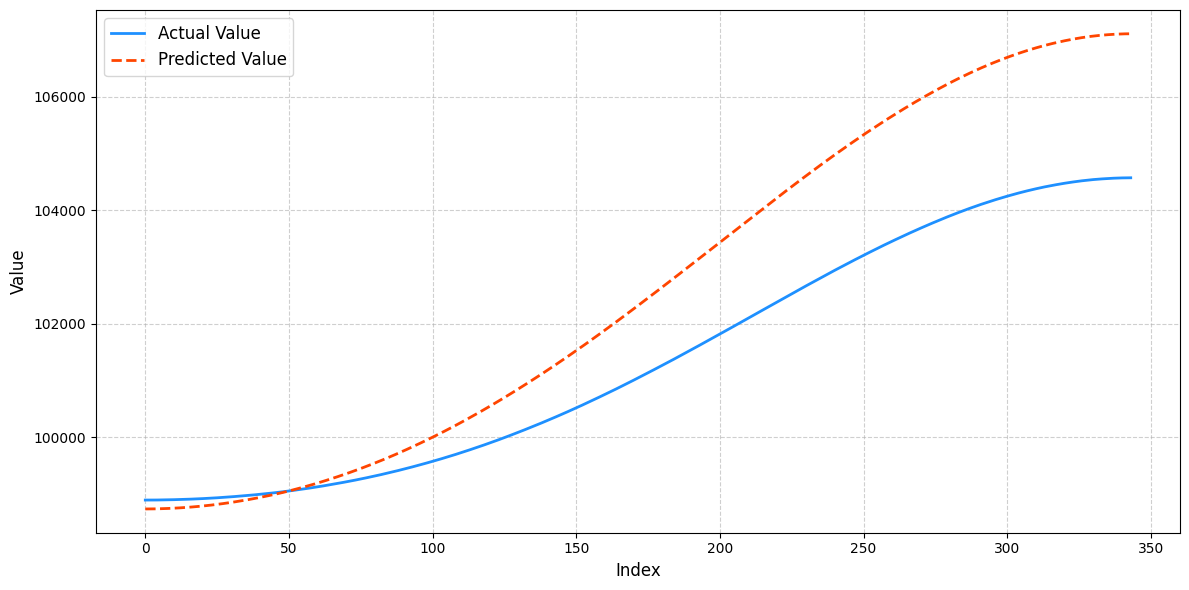

Predict on Test Set
MAE:  12763.611987224065
RMSE:  35733.348802521075
R2:  0.9082517114014045
Training time: 29.23 seconds


In [11]:
start = time.time()
HDEM = Dynamic_Weighted_Ensemble(X_train, X_val, X_test, Y_train, Y_val, Y_test, scaler)

HDEM.meta_model_name = 'gradientboosting'
# HDEM.meta_model_name = 'randomforest'
model_combinations = [['extratrees', 'randomforest', 'xgboost'], ['randomforest', 'mlp', 'gradientboosting'], ['lasso', 'xgboost', 'extratrees']]
HDEM.num_sub = len (model_combinations)
HDEM.init_base_sub(model_combinations)
sub_ensemble_result = HDEM.run_model()
end = time.time()
print(f'Training time: {end - start:.2f} seconds')